### Оценка Риска ДТП для Каршеринговой Компании

**Описание проекта:**

Задача — разработать систему, которая сможет оценивать риск ДТП по выбранному маршруту. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по изменению маршрута.

Идея создания такой системы находится на стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — выяснить, возможно ли предсказать вероятность ДТП, основываясь на исторических данных одного из регионов.

**Цели проекта:**

1. Создать модель предсказания ДТП (целевое значение — вероятность ДТП, где виновником является автомобиль).
2. Определить ключевые факторы, влияющие на вероятность ДТП.
3. Разработать рекомендации для улучшения системы оценки рисков.

**Основные этапы работы:**

1. **Исследование данных:**
   - Анализ и визуализация данных о ДТП, повреждениях и погодных условиях.
   - Изучение факторов, влияющих на вероятность аварий.

2. **Разработка модели:**
   - Создание модели предсказания риска ДТП на основе данных за 2012 год.
   - Отбор факторов, влияющих на вероятность аварий (например, возраст автомобиля, состояние водителя, дорожные условия).

3. **Анализ модели и выводы:**
   - Оценка качества модели, анализ ключевых факторов.
   - Разработка рекомендаций по улучшению системы предупреждения водителей.

**Планируемые результаты:**

- Разработанная модель, способная оценивать риск ДТП.
- Рекомендации для улучшения системы оценки рисков и безопасности водителей.
- Выявление дополнительных данных и датчиков, которые могут улучшить предсказание риска (например, камеры для оценки состояния водителя).

В ходе выполнения проекта будут созданы SQL-запросы, визуализации и модели машинного обучения для реализации и тестирования предложенной системы.

# Шаг 1: Подключение к базе данных и загрузка данных

In [1]:
import pandas as pd
from IPython.display import display
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Параметры подключения
db_config = {
    'user': 'praktikum_student',
    'password': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'database': 'data-science-vehicle-db',
}

# Создание URL подключения
db_url = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# Подключение к базе данных
engine = create_engine(db_url)

# Загрузка таблиц в pandas DataFrame
try:
    collisions_df = pd.read_sql_table('collisions', con=engine)
    parties_df = pd.read_sql_table('parties', con=engine)
    vehicles_df = pd.read_sql_table('vehicles', con=engine)
    
    print("Таблицы успешно загружены:")
    
except Exception as e:
    print("Ошибка при загрузке таблиц:", e)


Таблицы успешно загружены:


# Шаг 2. Проведите первичное исследование таблиц

In [3]:
# Функция для анализа таблиц
def analyze_table(df, table_name):
    print(f"--- Анализ таблицы: {table_name} ---\n")
    
    # Преобразование 'collision_time' в тип данных времени, если он существует
    if 'collision_time' in df.columns:
        try:
            # Попытка преобразовать время
            df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S', errors='coerce').dt.time
            print(f"\nУспешно преобразован столбец 'collision_time' в формат времени.\n")
        except Exception as e:
            print(f"Ошибка при преобразовании 'collision_time': {e}")
    
    # Основная информация о таблице
    print("Статистическая сводка:")
    display(df.describe(include='all'))
    print("\nИнформация о данных:")
    print(df.info())
    
    # Проверка на пропуски
    missing_values = df.isnull().sum()
    print("\nКоличество пропусков в каждом столбце:")
    print(missing_values[missing_values > 0])
    
    # Количество полных дубликатов
    duplicates = df.duplicated().sum()
    print(f"\nКоличество полных дубликатов: {duplicates}")

    
    # Уникальные значения и их количество в категориальных столбцах
    print("\nУникальные значения в категориальных столбцах:")
    for col in df.select_dtypes(include=['object']).columns:
        # Заполнение пропусков значением 'unknown'
        df[col].fillna('unknown')
        unique_count = df[col].value_counts(dropna=False)
        print(f"\nСтолбец '{col}':")
        display(unique_count)
    
    # Проверка на выбросы в числовых столбцах
    print("\nПроверка на выбросы в числовых столбцах:")
    numeric_columns = df.select_dtypes(include=['number']).columns
    for col in numeric_columns:
        q_low = df[col].quantile(0.05)
        q_high = df[col].quantile(0.95)
        outliers = df[(df[col] < q_low) | (df[col] > q_high)]
        print(f"\nСтолбец '{col}':")
        print(f"Количество выбросов: {len(outliers)}")
        if len(outliers) > 0:
            display(outliers)

# Анализируем каждую таблицу
analyze_table(collisions_df, 'collisions')

--- Анализ таблицы: collisions ---


Успешно преобразован столбец 'collision_time' в формат времени.

Статистическая сводка:


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
count,1400000,1400000,1400000,1.400000e+06,1059358,1.387781e+06,1392741,518779,1400000,1.400000e+06,1391834,1372046,1388176,1393181,1386907,1388012,1391407,1391593,1400000,1387692
unique,1400000,538,58,NaN,4,NaN,7,3,5,NaN,5,23,7,9,4,8,5,4,NaN,1440
top,4083072,1942,los angeles,NaN,south,NaN,clear,highway,small damage,NaN,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,NaN,15:00:00
freq,1,170335,433809,NaN,290513,NaN,1121048,416531,845771,NaN,1316453,438439,467109,891079,1242026,1346655,941950,916182,NaN,9157
mean,NaN,NaN,NaN,6.607115e+02,NaN,2.249087e-01,NaN,NaN,NaN,1.966006e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-04 05:29:34.738285568,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:00:00,NaN
25%,NaN,NaN,NaN,2.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-10-27 00:00:00,NaN
50%,NaN,NaN,NaN,1.000000e+02,NaN,0.000000e+00,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-02 00:00:00,NaN
75%,NaN,NaN,NaN,4.300000e+02,NaN,0.000000e+00,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-12 00:00:00,NaN
max,NaN,NaN,NaN,8.363520e+06,NaN,1.000000e+00,NaN,NaN,NaN,2.700000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-26 00:00:00,NaN



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   case_id                      1400000 non-null  object        
 1   county_city_location         1400000 non-null  object        
 2   county_location              1400000 non-null  object        
 3   distance                     1400000 non-null  float64       
 4   direction                    1059358 non-null  object        
 5   intersection                 1387781 non-null  float64       
 6   weather_1                    1392741 non-null  object        
 7   location_type                518779 non-null   object        
 8   collision_damage             1400000 non-null  object        
 9   party_count                  1400000 non-null  int64         
 10  primary_collision_factor     1391834 non-null  object   

case_id
4083072    1
5146396    1
5146421    1
5146420    1
5146418    1
          ..
4149420    1
4149416    1
4149415    1
4149414    1
4083051    1
Name: count, Length: 1400000, dtype: int64


Столбец 'county_city_location':


county_city_location
1942    170335
1900     49588
3711     27917
3400     26879
0109     23457
         ...  
4703         2
4707         1
1204         1
1911         1
4710         1
Name: count, Length: 538, dtype: int64


Столбец 'county_location':


county_location
los angeles        433809
orange             118276
san bernardino      79382
san diego           78391
riverside           69328
alameda             64553
sacramento          56988
santa clara         50786
ventura             32335
contra costa        31492
kern                29027
san joaquin         27263
fresno              26476
san mateo           24591
san francisco       20656
stanislaus          20103
tulare              19307
santa barbara       19207
monterey            17861
sonoma              17686
solano              14412
placer              13481
santa cruz          11570
san luis obispo     11505
merced              10858
marin                9601
shasta               7742
yolo                 7054
humboldt             6830
butte                6394
el dorado            5562
madera               5468
napa                 5295
kings                4672
nevada               4121
imperial             3955
mendocino            3852
sutter               3


Столбец 'direction':


direction
None     340642
south    290513
north    288614
east     240574
west     239657
Name: count, dtype: int64


Столбец 'weather_1':


weather_1
clear      1121048
cloudy      203030
raining      57976
None          7259
fog           6156
snowing       2571
other         1516
wind           444
Name: count, dtype: int64


Столбец 'location_type':


location_type
None            881221
highway         416531
ramp             75592
intersection     26656
Name: count, dtype: int64


Столбец 'collision_damage':


collision_damage
small damage     845771
scratch          346106
middle damage    166583
severe damage     30747
fatal             10793
Name: count, dtype: int64


Столбец 'primary_collision_factor':


primary_collision_factor
vehicle code violation    1316453
unknown                     37014
other than driver           29780
other improper driving       8470
None                         8166
fell asleep                   117
Name: count, dtype: int64


Столбец 'pcf_violation_category':


pcf_violation_category
speeding                             438439
improper turning                     238987
automobile right of way              158291
dui                                  110476
unsafe lane change                    93962
traffic signals and signs             72751
unsafe starting or backing            55674
unknown                               39558
wrong side of road                    33631
following too closely                 30033
other than driver (or pedestrian)     29780
None                                  27954
pedestrian right of way               15739
pedestrian violation                  15392
other hazardous violation             13851
improper passing                      12136
other improper driving                 8470
other equipment                        1747
hazardous parking                      1746
impeding traffic                        752
brakes                                  303
lights                                  209
fell asle


Столбец 'type_of_collision':


type_of_collision
rear end      467109
broadside     267368
sideswipe     241278
hit object    234024
other          78750
head-on        60059
overturned     39588
None           11824
Name: count, dtype: int64


Столбец 'motor_vehicle_involved_with':


motor_vehicle_involved_with
other motor vehicle               891079
fixed object                      226942
parked motor vehicle              104423
other object                       72677
bicycle                            41711
non-collision                      39905
motor vehicle on other roadway      9831
None                                6819
animal                              6191
train                                422
Name: count, dtype: int64


Столбец 'road_surface':


road_surface
dry         1242026
wet          136236
None          13093
snowy          7261
slippery       1384
Name: count, dtype: int64


Столбец 'road_condition_1':


road_condition_1
normal            1346655
construction        19332
None                11988
other                5688
holes                5484
obstruction          5276
loose material       2887
reduced width        1576
flooded              1114
Name: count, dtype: int64


Столбец 'lighting':


lighting
daylight                                   941950
dark with street lights                    291887
dark with no street lights                 106170
dusk or dawn                                47199
None                                         8593
dark with street lights not functioning      4201
Name: count, dtype: int64


Столбец 'control_device':


control_device
none               916182
functioning        470849
None                 8407
not functioning      3833
obscured              729
Name: count, dtype: int64


Столбец 'collision_time':


collision_time
NaT         12308
15:00:00     9157
17:30:00     9098
16:00:00     9046
17:00:00     8870
            ...  
04:56:00       84
04:31:00       83
04:21:00       81
04:49:00       80
05:09:00       75
Name: count, Length: 1441, dtype: int64


Проверка на выбросы в числовых столбцах:

Столбец 'distance':
Количество выбросов: 55308


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
89,4083412,5000,stanislaus,3696.0,east,0.0,cloudy,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2009-01-22,16:23:00
96,4083435,3017,orange,3450.0,south,0.0,clear,highway,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-20,09:30:00
104,4083466,5601,ventura,3168.0,north,0.0,clear,highway,scratch,1,vehicle code violation,improper turning,hit object,fixed object,dry,normal,dark with no street lights,none,2009-01-04,03:09:00
109,4083513,3300,riverside,9504.0,east,0.0,clear,highway,scratch,1,vehicle code violation,improper turning,hit object,fixed object,dry,normal,dusk or dawn,none,2009-01-11,16:50:00
180,4083848,4900,sonoma,6600.0,south,0.0,clear,highway,severe damage,1,vehicle code violation,improper turning,hit object,other object,dry,normal,daylight,none,2009-01-18,11:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399049,5558074,4800,solano,4224.0,east,0.0,clear,None,middle damage,2,other than driver,other than driver (or pedestrian),other,other object,dry,normal,dark with no street lights,none,2012-03-23,19:47:00
1399600,5631221,3604,san bernardino,3168.0,north,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2012-05-19,20:58:00
1399641,5635887,5600,ventura,4224.0,east,0.0,clear,None,middle damage,2,vehicle code violation,unsafe starting or backing,other,other object,dry,normal,daylight,none,2012-05-30,09:15:00
1399893,4041594,2700,monterey,22176.0,west,0.0,clear,highway,middle damage,2,other than driver,other than driver (or pedestrian),other,other object,dry,normal,dark with no street lights,none,2009-01-12,06:30:00



Столбец 'intersection':
Количество выбросов: 0

Столбец 'party_count':
Количество выбросов: 37683


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
86,4083403,3017,orange,60.0,south,0.0,clear,highway,scratch,5,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-17,10:40:00
149,4083714,4304,santa clara,120.0,east,0.0,clear,None,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2009-01-18,17:27:00
186,4083855,4905,sonoma,297.0,south,0.0,clear,highway,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2009-01-20,07:45:00
206,4083903,4900,sonoma,50.0,west,0.0,clear,None,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-08,15:58:00
212,4083915,3009,orange,300.0,west,0.0,clear,highway,scratch,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-28,15:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399696,5644835,3309,riverside,423.0,north,0.0,clear,None,middle damage,4,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,none,2012-04-27,15:15:00
1399705,5645226,4313,santa clara,200.0,west,0.0,clear,None,middle damage,4,other improper driving,other improper driving,other,other object,dry,normal,daylight,none,2012-06-02,16:10:00
1399713,5645801,3103,placer,10.0,south,0.0,clear,None,middle damage,4,vehicle code violation,traffic signals and signs,other,other object,dry,normal,daylight,functioning,2012-05-09,09:05:00
1399884,4039911,4803,solano,0.0,None,1.0,clear,None,middle damage,4,vehicle code violation,speeding,other,other object,dry,normal,dark with street lights,functioning,2009-01-10,01:12:00


In [4]:
analyze_table(parties_df, 'parties')

--- Анализ таблицы: parties ---

Статистическая сводка:


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
count,2.752408e+06,2752408,2.752408e+06,2748786,2.752408e+06,2.347006e+06,2678453,432288,2.240771e+06
unique,NaN,1400000,NaN,5,NaN,NaN,6,5,NaN
top,NaN,5196744,NaN,car,NaN,NaN,had not been drinking,G,NaN
freq,NaN,27,NaN,2469314,NaN,NaN,2124727,232901,NaN
mean,1.376204e+06,NaN,1.598029e+00,NaN,4.680000e-01,3.874724e+01,NaN,NaN,2.045055e-02
std,7.945519e+05,NaN,7.236567e-01,NaN,4.989750e-01,1.637851e+01,NaN,NaN,1.415356e-01
min,1.000000e+00,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00
25%,6.881028e+05,NaN,1.000000e+00,NaN,0.000000e+00,2.500000e+01,NaN,NaN,0.000000e+00
50%,1.376204e+06,NaN,1.000000e+00,NaN,0.000000e+00,3.600000e+01,NaN,NaN,0.000000e+00
75%,2.064306e+06,NaN,2.000000e+00,NaN,1.000000e+00,5.000000e+01,NaN,NaN,0.000000e+00



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB
None

Количество пропусков в каждом столбце:
party_type                3622
insurance_premium       405402
party_sobriety           73955
party_drug_physical    2320120
cellphone_in_use        511637
dtype: int64

Количество полных дубликатов: 0

Уникальные значения в категориальных столбцах:

Столбец 'case_id':


case_id
5196744    27
4926311    21
4067804    20
4882680    15
4751684    15
           ..
4898014     1
4898013     1
4898012     1
4898009     1
4770406     1
Name: count, Length: 1400000, dtype: int64


Столбец 'party_type':


party_type
car            2469314
road bumper     173488
building         48649
road signs       48456
other             8879
None              3622
Name: count, dtype: int64


Столбец 'party_sobriety':


party_sobriety
had not been drinking                     2124727
impairment unknown                         232901
not applicable                             169343
had been drinking, under influence         112413
None                                        73955
had been drinking, impairment unknown       21419
had been drinking, not under influence      17650
Name: count, dtype: int64


Столбец 'party_drug_physical':


party_drug_physical
None                     2320120
G                         232901
not applicable            169343
under drug influence       13215
sleepy/fatigued            12641
impairment - physical       4188
Name: count, dtype: int64


Проверка на выбросы в числовых столбцах:

Столбец 'id':
Количество выбросов: 275242


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...,...
755670,137616,4159129,1,car,1,26.0,had not been drinking,None,NaN
755671,137617,4159129,2,car,0,19.0,had not been drinking,None,NaN
755672,137618,4159129,3,car,0,69.0,had not been drinking,None,NaN
755673,137619,4159131,1,car,1,NaN,None,None,NaN



Столбец 'party_number':
Количество выбросов: 49201


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
22,217,3982941,4,road bumper,0,NaN,not applicable,not applicable,NaN
43,349,3987526,4,road bumper,0,NaN,not applicable,not applicable,NaN
44,361,3987542,4,road bumper,0,NaN,not applicable,not applicable,0.0
58,474,3987741,5,road bumper,0,NaN,had not been drinking,None,0.0
94,892,3996582,4,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...,...
2751950,2409291,5456378,4,car,0,69.0,had not been drinking,None,0.0
2751977,2409324,5456393,4,car,1,21.0,had not been drinking,None,0.0
2752069,2409435,5456449,4,car,0,30.0,had not been drinking,None,0.0
2752120,2409495,5456479,4,car,0,35.0,None,None,NaN



Столбец 'at_fault':
Количество выбросов: 0

Столбец 'insurance_premium':
Количество выбросов: 186768


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
14,142,3982898,2,car,0,71.0,had not been drinking,None,0.0
15,163,3982910,1,building,1,15.0,had not been drinking,None,0.0
29,261,3984245,2,road signs,0,74.0,had not been drinking,None,NaN
31,266,3984278,1,road signs,1,82.0,impairment unknown,G,0.0
...,...,...,...,...,...,...,...,...,...
2752396,777496,4532692,1,building,1,73.0,had not been drinking,None,NaN
2752397,908047,4612207,2,building,1,12.0,had not been drinking,None,0.0
2752398,1172803,4770406,1,building,0,12.0,had not been drinking,None,NaN
2752404,1644472,5041069,2,building,0,13.0,had not been drinking,None,0.0



Столбец 'cellphone_in_use':
Количество выбросов: 45825


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
16,170,3982914,1,building,1,21.0,had not been drinking,None,1.0
17,171,3982914,2,car,0,43.0,had not been drinking,None,1.0
38,311,3984383,3,road signs,0,29.0,"had been drinking, under influence",None,1.0
52,419,3987677,1,road bumper,1,NaN,had not been drinking,None,1.0
68,574,3990215,2,road bumper,0,NaN,not applicable,not applicable,1.0
...,...,...,...,...,...,...,...,...,...
2752377,2409791,5456646,2,car,0,71.0,had not been drinking,None,1.0
2752384,2409800,5456651,1,car,1,20.0,had not been drinking,None,1.0
2752385,2409801,5456651,2,car,0,58.0,had not been drinking,None,1.0
2752391,2409808,5456655,1,car,1,22.0,had not been drinking,None,1.0


In [5]:
analyze_table(vehicles_df, 'vehicles')

--- Анализ таблицы: vehicles ---

Статистическая сводка:


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
count,1.021234e+06,1021234,1.021234e+06,1021234,997575,996652.000000
unique,NaN,792642,NaN,5,2,NaN
top,NaN,5196744,NaN,sedan,auto,NaN
freq,NaN,27,NaN,488665,502243,NaN
mean,7.601628e+05,NaN,1.609510e+00,NaN,NaN,5.137088
std,4.386194e+05,NaN,6.790946e-01,NaN,NaN,3.110310
min,1.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000
25%,3.806942e+05,NaN,1.000000e+00,NaN,NaN,3.000000
50%,7.617625e+05,NaN,2.000000e+00,NaN,NaN,5.000000
75%,1.141348e+06,NaN,2.000000e+00,NaN,NaN,7.000000



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB
None

Количество пропусков в каждом столбце:
vehicle_transmission    23659
vehicle_age             24582
dtype: int64

Количество полных дубликатов: 0

Уникальные значения в категориальных столбцах:

Столбец 'case_id':


case_id
5196744    27
5263678    13
4503437    11
4926311    10
4044608     8
           ..
4479098     1
4479099     1
4479064     1
4479066     1
5305007     1
Name: count, Length: 792642, dtype: int64


Столбец 'vehicle_type':


vehicle_type
sedan        488665
coupe        442780
hatchback     45595
minivan       43000
other          1194
Name: count, dtype: int64


Столбец 'vehicle_transmission':


vehicle_transmission
auto      502243
manual    495332
None       23659
Name: count, dtype: int64


Проверка на выбросы в числовых столбцах:

Столбец 'id':
Количество выбросов: 102124


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
1,1,3858022,1,sedan,auto,3.0
10,6,3899454,1,hatchback,auto,4.0
31,1277,4012051,1,hatchback,manual,5.0
32,1287,4014901,2,hatchback,manual,9.0
33,1290,4014908,1,hatchback,manual,5.0
...,...,...,...,...,...,...
869384,75112,4162222,2,sedan,manual,3.0
869385,75117,4162231,1,sedan,manual,3.0
869386,75118,4162232,2,sedan,manual,3.0
869387,75120,4162238,1,sedan,manual,3.0



Столбец 'party_number':
Количество выбросов: 13166


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
13,1175720,5305033,4,sedan,manual,6.0
14,1175724,5305034,4,sedan,manual,11.0
75,1175937,5305224,4,sedan,manual,11.0
85,1227472,5357854,4,sedan,manual,5.0
100,1230524,5360895,4,sedan,manual,2.0
...,...,...,...,...,...,...
1020933,1173586,5302948,4,sedan,manual,1.0
1020964,1173857,5303190,4,sedan,manual,5.0
1021114,1175055,5304348,4,sedan,manual,6.0
1021115,1175060,5304349,4,sedan,manual,7.0



Столбец 'vehicle_age':
Количество выбросов: 70257


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
18,1175752,5305056,1,sedan,manual,0.0
22,1175771,5305066,2,sedan,manual,0.0
23,1175775,5305069,1,sedan,manual,0.0
78,1175956,5305239,1,sedan,manual,0.0
101,1230532,5360900,1,sedan,manual,0.0
...,...,...,...,...,...,...
1021193,1175427,5304757,2,sedan,manual,0.0
1021194,1175431,5304766,1,sedan,manual,0.0
1021199,1175446,5304788,1,sedan,manual,13.0
1021212,1175574,5304884,1,sedan,manual,0.0


### Обобщенный вывод по всем таблицам

Анализ всех трёх таблиц — `collisions`, `parties` и `vehicles` — выявил ключевые особенности и проблемы, которые необходимо учесть при подготовке данных для построения модели предсказания ДТП с участием каршеринговых автомобилей. Вот основные выводы и рекомендации:

### 1. **Общие характеристики и структура данных**
- Данные охватывают различную информацию о ДТП, участниках аварий и характеристиках транспортных средств. Между таблицами установлены связи через столбец `case_id`, что позволяет объединить данные для создания комплексного набора признаков.
- В таблице `collisions` содержатся данные о происшествиях, такие как дата, время, место и условия на дороге.
- Таблица `parties` описывает характеристики участников ДТП, их поведение, состояние и страховые данные.
- Таблица `vehicles` предоставляет информацию о транспортных средствах, таких как тип кузова, возраст и тип трансмиссии.

### 2. **Качество данных и пропуски**
- Во всех трёх таблицах присутствуют пропуски. Это может негативно сказаться на качестве модели. Пропуски наиболее часто встречаются в следующих столбцах:
  - **`collisions`**: `intersection`, `weather_1`, `collision_damage`, `primary_coll_factor` и других.
  - **`parties`**: `party_type`, `insurance_premium`, `party_sobriety`, `party_drug_physical`, `cellphone_in_use`.
  - **`vehicles`**: `vehicle_type` и `vehicle_transmission`.
- Пропуски могут быть обусловлены отсутствием информации в отчётах о ДТП или ошибками при вводе данных. Их необходимо обработать перед построением модели, чтобы минимизировать влияние на результат.

### 3. **Аномалии и выбросы**
- В каждой таблице были выявлены выбросы, которые могут указывать на ошибки ввода или аномальные события:
  - В таблице `collisions` возможны выбросы в `distance` и `collision_time`.
  - В таблице `parties` выбросы присутствуют в таких столбцах, как `insurance_premium` и `party_number`.
  - В таблице `vehicles` выбросы могут быть в столбцах `vehicle_age` и `id`.
- Выбросы требуют дополнительного анализа для принятия решения об их удалении или корректировке.

### 4. **Анализ категориальных переменных**
- Во всех таблицах встречаются категориальные переменные с большим количеством уникальных значений, что может усложнить обучение модели. Необходимо рассмотреть возможности группировки редко встречающихся категорий или преобразования их в числовые признаки.
- Некоторые категориальные признаки, такие как `primary_coll_factor` в `collisions` и `party_sobriety` в `parties`, требуют отдельного внимания и могут существенно повлиять на модель.

### 5. **Рекомендации по обработке данных**
- **Обработка пропусков**: Рассмотреть заполнение пропусков средними значениями, медианой или наиболее частыми категориями. Для категориальных признаков можно использовать значение `unknown`.
- **Обработка выбросов**: Проверить и удалить выбросы или преобразовать их в корректные значения, если они искажают данные.
- **Группировка категорий**: Объединить редко встречающиеся категории, чтобы уменьшить количество уникальных значений.
- **Создание новых признаков**: Использовать комбинации существующих признаков для создания новых, которые могут улучшить предсказательную способность модели (например, учёт времени суток, дня недели, состояния водителя и состояния транспортного средства).

### 6. **Взаимосвязи между таблицами и их влияние на модель**
- Поскольку таблицы связаны через `case_id`, их объединение позволит создать единый датасет для моделирования. Это даст возможность учитывать все аспекты происшествия, такие как состояние водителя, тип транспортного средства и дорожные условия.
- Наиболее важные признаки для модели могут включать в себя комбинации характеристик ДТП (например, освещение, время и тип происшествия), поведение участников (трезвость, использование мобильного телефона) и характеристики транспортных средств (возраст, тип).

### 7. **Заключение**
Данные обладают достаточной информацией для построения предсказательной модели, однако их качество требует значительных усилий по очистке и предобработке. Обработка пропусков, выбросов и оптимизация категориальных признаков станут ключевыми шагами на пути к успешной модели. Комплексный подход к обработке данных, учёт всех их особенностей и взаимосвязей обеспечат высокую точность и обобщающую способность будущей модели предсказания ДТП.

### Шаг 3. Проведите статистический анализ факторов ДТП

,month,collision_count
0,1.0,132044
1,2.0,128858
2,3.0,139581
3,4.0,130180
4,5.0,130316
5,6.0,102594
6,7.0,102227
7,8.0,104089
8,9.0,105159
9,10.0,112237


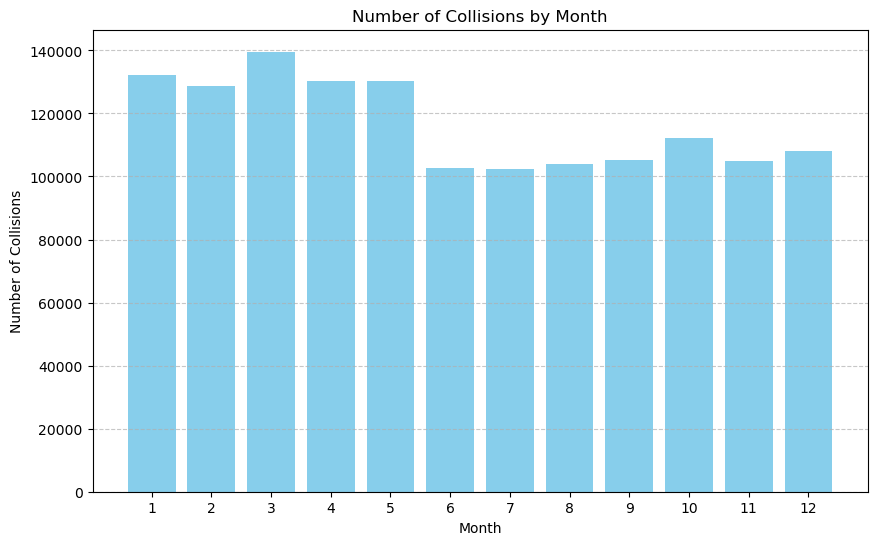

In [6]:
# SQL-запрос для подсчета количества ДТП по месяцам
query = """
SELECT
    EXTRACT(MONTH FROM collision_date) AS month,
    COUNT(*) AS collision_count
FROM collisions
GROUP BY month
ORDER BY month;
"""

# Выполнение запроса и загрузка данных в DataFrame
collisions_by_month = pd.read_sql(query, engine)


# Вывод результата
display(collisions_by_month)

# Построим столбчатую диаграмму количества ДТП по месяцам
plt.figure(figsize=(10, 6))
plt.bar(collisions_by_month['month'], collisions_by_month['collision_count'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Collisions')
plt.title('Number of Collisions by Month')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


На основании полученных данных и графика можно сделать следующие выводы:

### Вывод

1. **Наибольшее количество аварий**:
   - Март (139,581), январь (132,044), и апрель (130,180) — месяцы с наибольшим количеством ДТП. Это может быть связано с увеличением трафика после зимнего периода, а также с более благоприятными погодными условиями, которые способствуют увеличению количества поездок.

2. **Наименьшее количество аварий**:
   - Июнь (102,594), июль (102,227), и август (104,089) — месяцы с наименьшим количеством ДТП. Это может объясняться летними отпусками, когда люди меньше времени проводят в городах, или общей тенденцией к снижению плотности движения на дорогах в это время года.

3. **Среднее количество аварий в другие месяцы**:
   - Ноябрь (104,770) и декабрь (107,945) имеют относительно стабильное количество ДТП, что может свидетельствовать о подготовке водителей к зимним условиям и более осторожном вождении в этот период.
   - Сентябрь (105,159) и октябрь (112,237) также показывают умеренный уровень аварийности, что может быть связано с возвращением людей к обычному ритму жизни после отпусков и началом учебного года.

4. **Пики и спады**:
   - Самые высокие пики аварийности приходятся на начало весны (март), что может указывать на сложные погодные условия или изменения в поведении водителей.
   - Летние месяцы имеют наименьшее количество ДТП, что также отражает особенности сезонного поведения на дорогах.

### Рекомендации

- **Планирование превентивных мер**: В марте и январе стоит усилить меры по обеспечению безопасности на дорогах, такие как дополнительные информационные кампании и контроль за соблюдением правил дорожного движения.
- **Исследование сезонных факторов**: Провести дополнительное исследование факторов, влияющих на снижение аварийности в летние месяцы, чтобы использовать эти знания для уменьшения числа аварий в другие периоды.
- **Планирование ресурсов**: Учитывать сезонные колебания при распределении ресурсов экстренных служб и планировании дорожных работ.

### Задачи для коллег

1. **Анализ серьёзности повреждений транспортного средства в зависимости от состояния дороги:**
   - Связать таблицы `collisions` и `parties`.
   - Определить, как состояние дорожного покрытия влияет на уровень повреждений автомобиля.

2. **Самые частые причины ДТП:**
   - Использовать таблицу `parties`.
   - Определить, какие причины аварий наиболее распространены среди участников.

3. **Анализ типов столкновений в зависимости от времени суток:**
   - Связать таблицы `collisions` и `parties`.
   - Проанализировать, какие типы столкновений чаще происходят в дневное и ночное время.

4. **Влияние возраста автомобиля на вероятность вины в ДТП:**
   - Связать таблицы `vehicles` и `parties`.
   - Выяснить, как возраст автомобиля влияет на вероятность того, что его водитель окажется виновным в аварии.

5. **Анализ влияния погодных условий на частоту использования мобильного телефона:**
   - Связать таблицы `collisions` и `parties`.
   - Проанализировать, как погодные условия влияют на использование водителями мобильных телефонов во время аварий.

6. **Взаимосвязь количества участников и типа столкновения:**
   - Связать таблицы `collisions` и `parties`.
   - Определить, как количество участников ДТП (транспортных средств и пешеходов) связано с типом столкновения.

### Примеры:

#### Задача 1: Анализ серьёзности повреждений транспортного средства в зависимости от состояния дороги

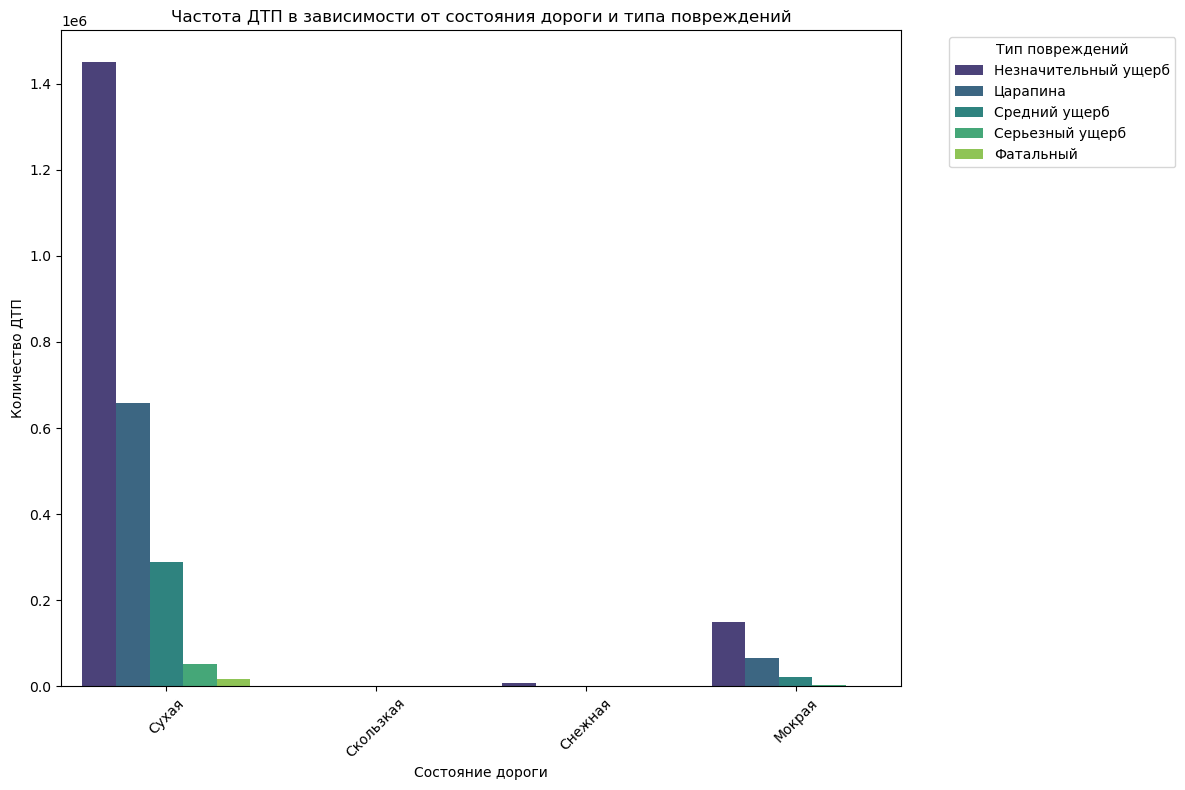

In [7]:
# SQL-запрос для получения количества ДТП по состоянию дороги и степени повреждений
query = """
SELECT c.road_surface, c.collision_damage, COUNT(*) as count
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
GROUP BY c.road_surface, c.collision_damage
ORDER BY c.road_surface, count DESC;
"""

# Выполнение запроса
df_road_damage = pd.read_sql(query, engine)

# Перевод категорий состояния дороги и повреждений на русский
road_surface_translation = {
    'dry': 'Сухая', 
    'wet': 'Мокрая', 
    'snowy': 'Снежная', 
    'slippery': 'Скользкая'
}
collision_damage_translation = {
    'small damage': 'Незначительный ущерб',
    'scratch': 'Царапина',
    'middle damage': 'Средний ущерб',
    'severe damage': 'Серьезный ущерб',
    'fatal': 'Фатальный'
}

# Перевод значений
df_road_damage['road_surface'] = df_road_damage['road_surface'].map(road_surface_translation)
df_road_damage['collision_damage'] = df_road_damage['collision_damage'].map(collision_damage_translation)

# Построение графика
plt.figure(figsize=(12, 8))
sns.barplot(x='road_surface', y='count', hue='collision_damage', data=df_road_damage, palette='viridis')
plt.title('Частота ДТП в зависимости от состояния дороги и типа повреждений')
plt.xlabel('Состояние дороги')
plt.ylabel('Количество ДТП')
plt.legend(title='Тип повреждений', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Задача 2: Влияние возраста автомобиля на вероятность вины в ДТП

c:\Users\ivano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ivano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


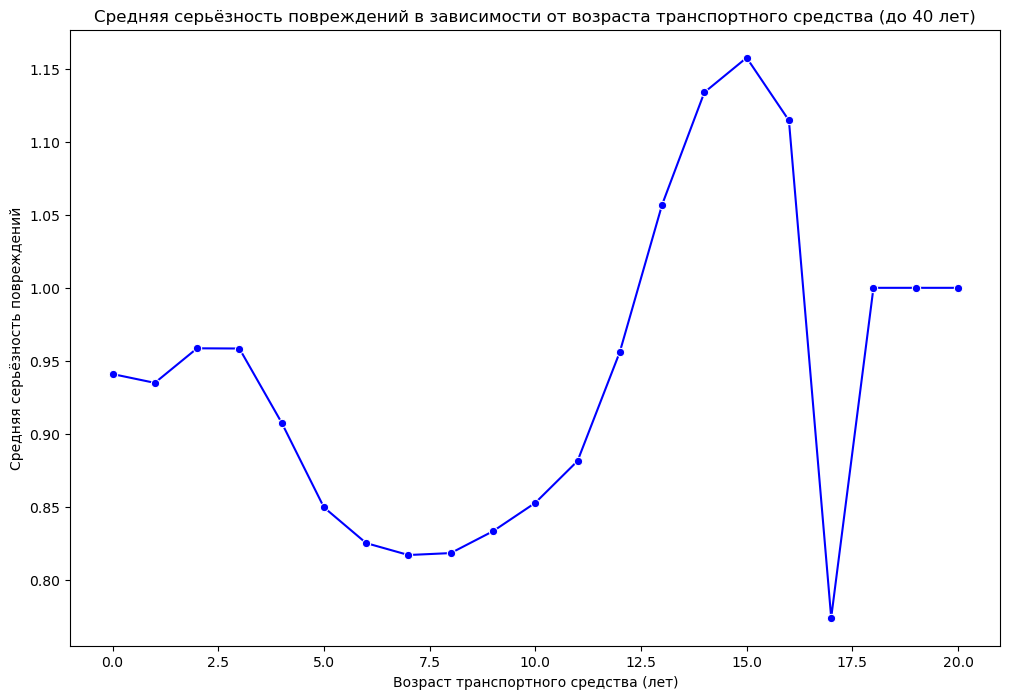

In [8]:
# SQL-запрос для получения возраста транспортного средства и серьёзности повреждений
query = """
SELECT v.vehicle_age, 
       CASE
           WHEN c.collision_damage = 'small damage' THEN 1
           WHEN c.collision_damage = 'scratch' THEN 0
           WHEN c.collision_damage = 'middle damage' THEN 2
           WHEN c.collision_damage = 'severe damage' THEN 3
           WHEN c.collision_damage = 'fatal' THEN 4
           ELSE NULL
       END as damage_severity
FROM collisions c
JOIN vehicles v ON c.case_id = v.case_id
WHERE v.vehicle_age IS NOT NULL 
  AND c.collision_damage IS NOT NULL 
  AND v.vehicle_age <= 40;
"""

# Выполнение запроса
df_vehicle_damage = pd.read_sql(query, engine)

# Замена inf значений на NaN
df_vehicle_damage.replace([np.inf, -np.inf], np.nan, inplace=True)

# Группировка по возрасту транспортного средства и расчет средней серьёзности повреждений
df_avg_damage = df_vehicle_damage.groupby('vehicle_age')['damage_severity'].mean().reset_index()

# Построение графика
plt.figure(figsize=(12, 8))
sns.lineplot(x='vehicle_age', y='damage_severity', data=df_avg_damage, marker='o', color='b')
plt.title('Средняя серьёзность повреждений в зависимости от возраста транспортного средства (до 40 лет)')
plt.xlabel('Возраст транспортного средства (лет)')
plt.ylabel('Средняя серьёзность повреждений')
plt.show()

### Выводы по графикам:

1. **Частота ДТП в зависимости от состояния дороги и типа повреждений**:
   - На графике видно, что наибольшее количество аварий происходит на сухом дорожном покрытии. Причина может заключаться в том, что водители менее осторожны на сухой дороге и более склонны превышать скорость.
   - Второе место по частоте занимают аварии на мокрой дороге. Несмотря на меньшую частоту по сравнению с сухой дорогой, доля серьёзных и фатальных аварий выше, что свидетельствует о более высокой опасности таких условий.
   - Скользкая и снежная дороги имеют минимальное количество аварий, что может быть связано с тем, что такие условия заставляют водителей быть более внимательными или воздерживаться от вождения.

2. **Средняя серьёзность повреждений в зависимости от возраста транспортного средства**:
   - График показывает, что с увеличением возраста транспортного средства до 5 лет средняя серьёзность повреждений уменьшается. Это может объясняться тем, что новые автомобили имеют более продвинутые системы безопасности, что снижает тяжесть последствий при ДТП.
   - Однако начиная с возраста 5 лет серьёзность повреждений возрастает, достигая пика в районе 13–15 лет. Это может быть связано с износом транспортного средства, ухудшением технического состояния и снижением эффективности систем безопасности.
   - После 15 лет серьёзность повреждений снова снижается, что может объясняться тем, что такие автомобили используются реже или водителями с более осторожным стилем вождения.
   - Резкий скачок серьёзности повреждений в 17 лет может быть связан с небольшой выборкой данных для автомобилей такого возраста или специфическими особенностями эксплуатации таких транспортных средств.

**Рекомендации**:
- Внимание стоит уделить профилактике аварий на мокрой дороге, например, улучшая дренажные системы на дорогах или повышая информированность водителей о рисках.
- Особое внимание нужно уделять транспортным средствам старше 5 лет: регулярные техосмотры и профилактические работы помогут снизить вероятность серьёзных повреждений при авариях.

# Шаг 4: Создание модели для оценки водительского риска



In [21]:
# SQL-запрос для получения необходимых данных
query = """
SELECT
    p.party_type,
    p.party_sobriety,
    p.at_fault,
    c.collision_damage,
    c.road_surface,
    c.weather_1,
    v.vehicle_age
FROM parties p
JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
JOIN collisions c ON p.case_id = c.case_id
WHERE v.vehicle_age IS NOT NULL
    AND c.collision_damage != 'scratch'
    AND p.party_type = 'car'
    AND c.collision_date >= '2012-01-01' AND c.collision_date < '2013-01-01';
"""

# Выполнение запроса и загрузка данных в DataFrame
df_risk = pd.read_sql(query, engine)

# Отбор факторов
columns = [
    'party_type',        # Тип участника происшествия
    'party_sobriety',    # Уровень трезвости виновника
    'at_fault',          # Вина участника (0 - не виновен, 1 - виновен)
    'road_surface',      # Состояние дороги
    'weather_1',        # Погодные условия
    'vehicle_age'       # Возраст автомобиля
]

# Создание нового DataFrame с отобранными факторами
selected_data = df_risk[columns]
analyze_table(selected_data, 'risk_data')

--- Анализ таблицы: risk_data ---

Статистическая сводка:


,party_type,party_sobriety,at_fault,road_surface,weather_1,vehicle_age
count,54554,53718,54554.000000,54225,54389,54554.000000
unique,1,6,NaN,4,7,NaN
top,car,had not been drinking,NaN,dry,clear,NaN
freq,54554,47189,NaN,48713,43726,NaN
mean,NaN,NaN,0.504839,NaN,NaN,4.856472
std,NaN,NaN,0.499981,NaN,NaN,3.234503
min,NaN,NaN,0.000000,NaN,NaN,0.000000
25%,NaN,NaN,0.000000,NaN,NaN,3.000000
50%,NaN,NaN,1.000000,NaN,NaN,4.000000
75%,NaN,NaN,1.000000,NaN,NaN,7.000000



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   party_type      54554 non-null  object
 1   party_sobriety  53718 non-null  object
 2   at_fault        54554 non-null  int64 
 3   road_surface    54225 non-null  object
 4   weather_1       54389 non-null  object
 5   vehicle_age     54554 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.5+ MB
None

Количество пропусков в каждом столбце:
party_sobriety    836
road_surface      329
weather_1         165
dtype: int64

Количество полных дубликатов: 53551

Уникальные значения в категориальных столбцах:

Столбец 'party_type':


party_type
car    54554
Name: count, dtype: int64


Столбец 'party_sobriety':


party_sobriety
had not been drinking                     47189
had been drinking, under influence         4384
impairment unknown                         1095
None                                        836
had been drinking, not under influence      564
had been drinking, impairment unknown       249
not applicable                              237
Name: count, dtype: int64


Столбец 'road_surface':


road_surface
dry         48713
wet          5119
snowy         351
None          329
slippery       42
Name: count, dtype: int64


Столбец 'weather_1':


weather_1
clear      43726
cloudy      8178
raining     2115
fog          173
None         165
snowing      154
other         32
wind          11
Name: count, dtype: int64


Проверка на выбросы в числовых столбцах:

Столбец 'at_fault':
Количество выбросов: 0

Столбец 'vehicle_age':
Количество выбросов: 1761


,party_type,party_sobriety,at_fault,road_surface,weather_1,vehicle_age
1,car,had not been drinking,1,dry,clear,13
78,car,had not been drinking,1,dry,clear,14
82,car,had not been drinking,0,dry,clear,14
89,car,had not been drinking,1,dry,clear,16
120,car,had not been drinking,1,wet,fog,12
...,...,...,...,...,...,...
54401,car,had not been drinking,0,wet,cloudy,12
54444,car,had not been drinking,0,dry,clear,13
54459,car,had not been drinking,0,wet,raining,12
54466,car,had not been drinking,0,dry,clear,12


In [22]:
from sklearn.model_selection import train_test_split

# Определение целевой переменной и признаков
X = selected_data.drop('at_fault', axis=1)
y = selected_data['at_fault']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
